In [6]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from keras.models import load_model
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tifffile
import os

In [ ]:
eval_folder_list = ["../jupyter_data/eval_enface_roi_adjust/c1", "../jupyter_data/eval_enface_roi_adjust/c2", "../jupyter_data/eval_enface_roi_adjust/c3"]

In [ ]:
from read_roi import read_roi_zip


def read_roi(roi_path):
    roi = read_roi_zip(roi_path)
    roi_coords = []
    for i, v in enumerate(roi.values()):
        if v['type'] == 'rectangle':
            roi_x, roi_y = v['left'], v['top']
            roi_width, roi_height = v['width'], v['height']
            roi_coords.append([roi_x, roi_y, roi_width, roi_height])
    return roi_coords


In [ ]:
eval_data_list = []
eval_tifpath_list = []
for channel_folder in eval_folder_list:
    for folder in os.listdir(channel_folder):
        image_folder = os.path.join(channel_folder, folder)
        files_list = os.listdir(image_folder)
        # files_list = [os.path.join(image_folder, file) for file in files_list]
        # if len(files_list) != 2:
        #     print("Number of files is not 2.")
        #     continue
        golgi_dict = {}
        for file in files_list:
            if file == "pred.tif":
                continue
            elif file.endswith("tif"):
                tif_path = os.path.join(image_folder, file)
            elif file.endswith("zip"):
                roi_path = os.path.join(image_folder, file)
        # if files_list[0].endswith("tif"):
        #     tif_path, roi_path = files_list
        # else:
        #     roi_path, tif_path = files_list
        eval_tifpath_list.append(tif_path)
        giantin_channel = int(channel_folder[-1]) - 1
        golgi_image = tifffile.imread(tif_path)
        golgi_dict['golgi_image'] = golgi_image
        golgi_dict['giantin_channel'] = giantin_channel
        golgi_dict['roi_coords'] = read_roi(roi_path)

        eval_data_list.append(golgi_dict)
    print("Got {} golgi images.".format(len(eval_data_list)))

In [91]:
# read newest data
path = "Z:/Divyanshu/Jin Chun/enface averaging/bcop"
eval_data_list = []
eval_tifpath_list = []
for file_name in os.listdir(path):
    golgi_dict = {}
    tif_path = os.path.join(path, file_name)
    golgi_image = tifffile.imread(tif_path)
    eval_tifpath_list.append(tif_path)
    golgi_dict['golgi_image'] = golgi_image
    golgi_dict['giantin_channel'] = 0

    eval_data_list.append(golgi_dict)

print("Got {} golgi images.".format(len(eval_data_list)))

Got 5 golgi images.


In [9]:
from train_src.metrics import *

# load model

model_path = "../model/valDice0.6752_valMeanIoU0.5303.h5"
model_path = "../model/valDice0.6965_valMeanIoU0.5542.h5"
model_path = "../model/valDice0.7042_valMeanIoU0.5532.h5"
model = load_model(model_path, compile=False)
model.compile(loss=bce_dice_loss,
              metrics=["binary_crossentropy", mean_iou, dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         input[0][0]                      
__________________________________________________________________________________________________
bn11_1 (BatchNormalization)     (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
relu11_1 (Activation)           (None, 256, 256, 32) 0           bn11_1[0][0]                     
______________________________________________________________________________________________

In [92]:
giantin_tif_list = []
golgi_image_list = []
roi_coords_list = []

for data in eval_data_list:
    golgi_image = data['golgi_image']
    giantin_channel = data['giantin_channel']
    # roi = data['roi_coords']
    giantin_tif = golgi_image[giantin_channel]
    giantin_tif_list.append(giantin_tif)
    golgi_image_list.append(golgi_image)
    # roi_coords_list.append(roi)

In [93]:
from jupyter_src.functions import padding_image

padded_giantin_list, patches_giantin_list = padding_image(giantin_tif_list, do_patchify=True,
                                                          clear_edge_roi=False, patch_size=(256, 256),
                                                          patch_step=206)

1080
1080
1080
1080
1080


In [94]:
from jupyter_src.functions import get_img_unpad

unpadded_test = get_img_unpad(padded_giantin_list[0], 78)

In [13]:
import numpy as np

np.equal(unpadded_test, giantin_tif_list[0]).all()

ValueError: operands could not be broadcast together with shapes (924,924) (880,880) 

In [95]:
from jupyter_src.functions import make_model_input

X_eval, num_patches_perimage = make_model_input(patches_giantin_list, do_norm=True, data_shape=(-1, 256, 256, 1))

In [96]:
X_eval.shape

(125, 256, 256, 1)

In [98]:
pred = model.predict(X_eval, verbose=1)

4/4 [==============================] - 10s 2s/step


In [99]:
from jupyter_src.functions import pred_to_mask, unpadding_image

pred_mask, pred_mask_patches = pred_to_mask(pred, num_patches_perimage)
unpad_mask_list = unpadding_image(pred_mask, giantin_tif_list)

In [100]:
threshold = 0.2

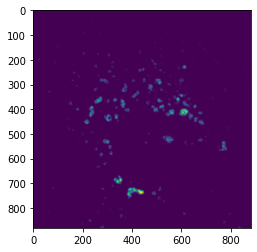

In [87]:
plt.imshow(golgi_image_list[2][0])

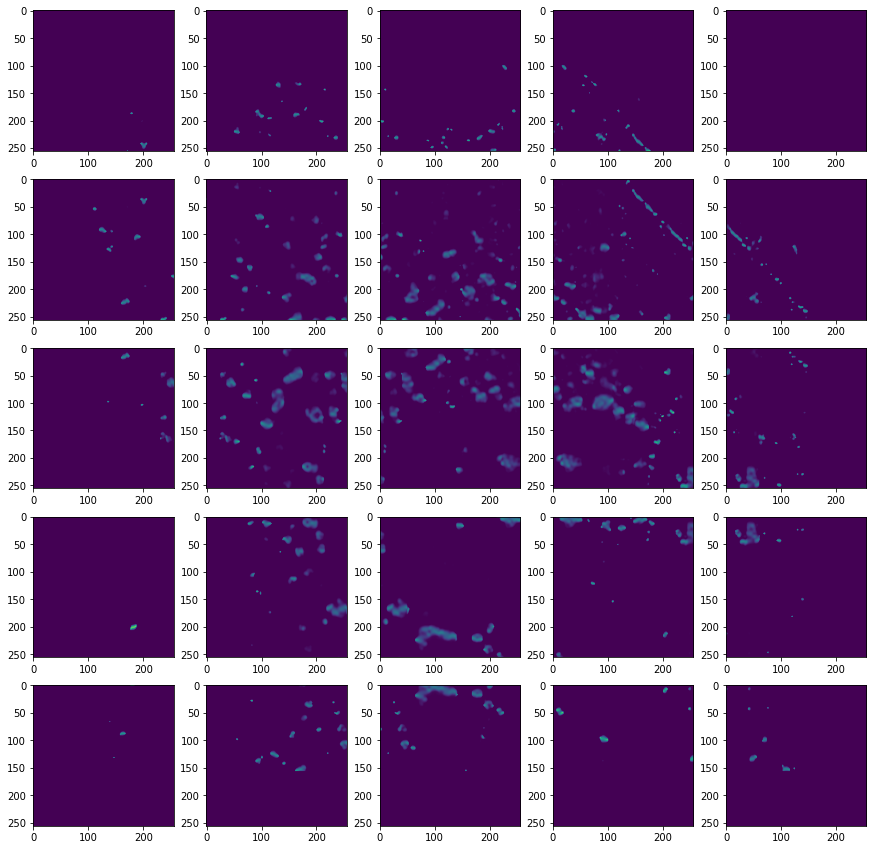

In [97]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(np.array(X_eval[50+i]))

24


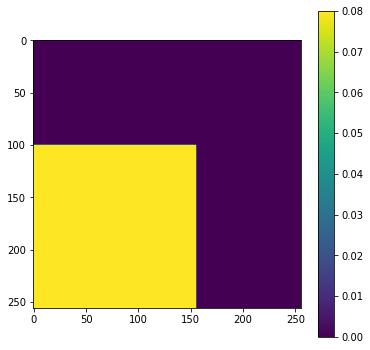

In [90]:
import random
r = random.randint(0,X_eval.shape[0])
plt.figure(figsize=(6,6))
print(r)
plt.imshow(np.array(X_eval[54]))
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(unpad_mask_list[0]))
tifffile.imsave("test_pred.tif",np.array(unpad_mask_list[0]))

In [102]:
tifffile.imsave("test_pred_2.tif",np.array(unpad_mask_list[2]))

In [33]:
save_pred_result = False
roi_flag = False

Z:/Divyanshu/Jin Chun/enface averaging/bcop\20220128_Bcop-488_GalT-mCherry_giantin-647-10-Airyscan Processing-01-BGST.tif


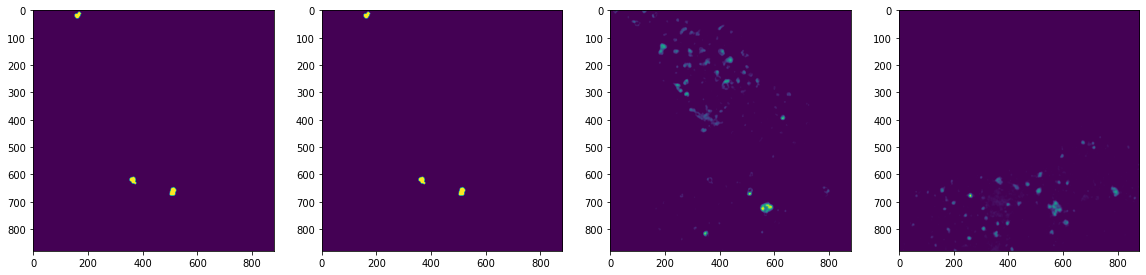

Z:/Divyanshu/Jin Chun/enface averaging/bcop\20220128_Bcop-488_GalT-mCherry_giantin-647-6-Airyscan Processing-01-BGST.tif


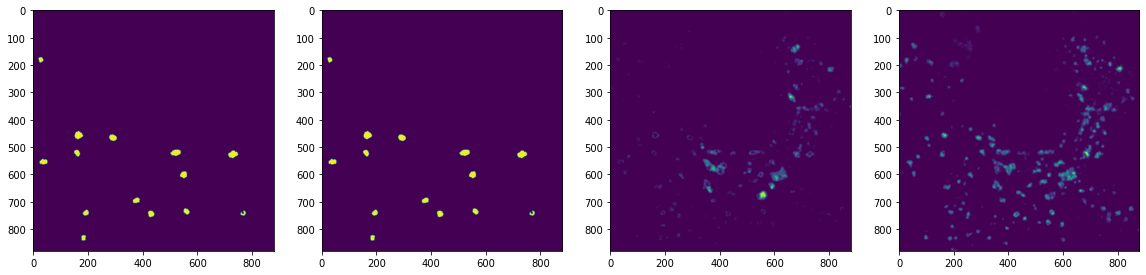

Z:/Divyanshu/Jin Chun/enface averaging/bcop\20220128_Bcop-488_GalT-mCherry_giantin-647-7-Airyscan Processing-01-BGST.tif


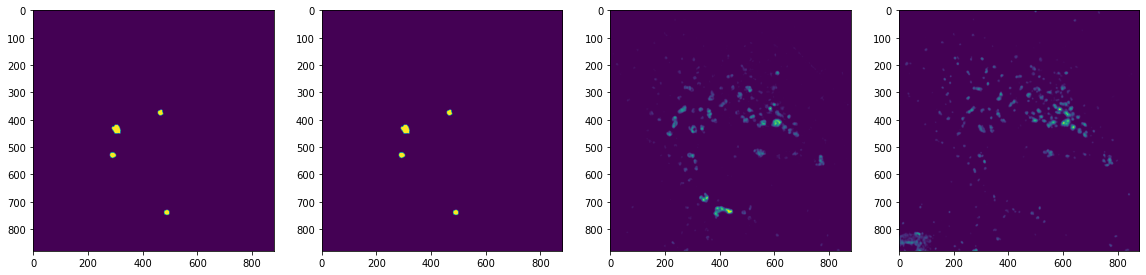

Z:/Divyanshu/Jin Chun/enface averaging/bcop\20220128_Bcop-488_GalT-mCherry_giantin-647-8-Airyscan Processing-01-BGST.tif


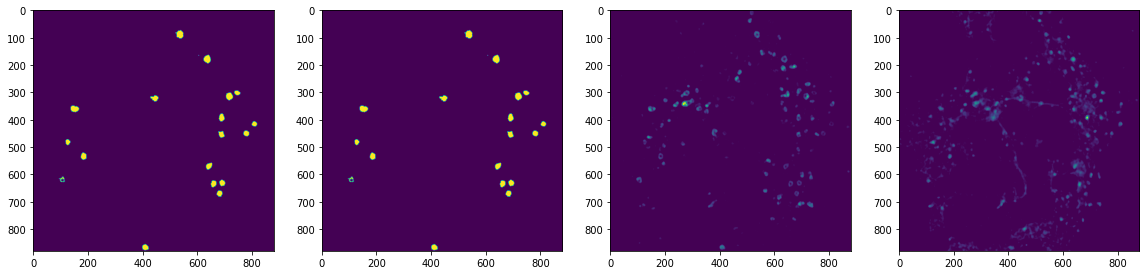

Z:/Divyanshu/Jin Chun/enface averaging/bcop\20220128_Bcop-488_GalT-mCherry_giantin-647-9-Airyscan Processing-01-BGST.tif


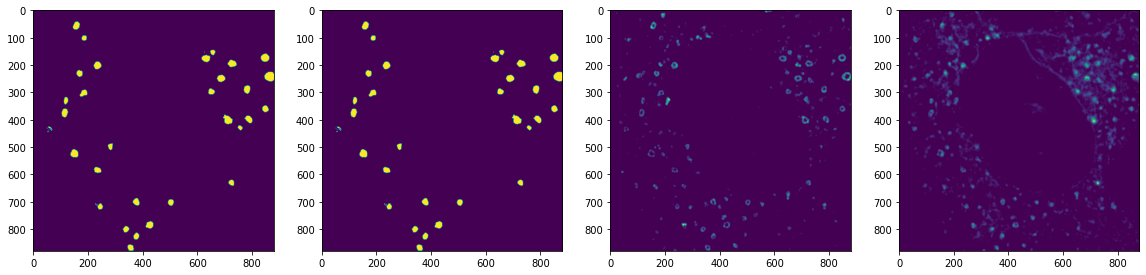

In [101]:
# show mask, raw giantin and normalzed giantin
import tensorflow as tf
from matplotlib.patches import Rectangle

for k in range(len(pred_mask)):
    golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
    print(eval_tifpath_list[k])
    plt.figure(figsize=(25,25))
    plt.subplot(151)
    pred_thresholded = np.array(unpad_mask_list[k] > threshold, dtype=np.bool_)
    plt.imshow(pred_thresholded)
    plt.subplot(152)
    plt.imshow(pred_thresholded)
    ax = plt.gca()
    if roi_flag:
        for coords in roi_coords_list[k]:
            rect = Rectangle((coords[0],coords[1]),coords[2],coords[3], fill=False)
            ax.add_patch(rect)
    # plt.imshow(np.array(unpad_mask_list[k]>0))
    plt.subplot(153)
    plt.imshow(golgi_image_list[k][0])
    plt.subplot(154)
    plt.imshow(golgi_image_list[k][1])
    if golgi.shape[2] == 3:
        plt.subplot(155)
        plt.imshow(golgi_image_list[k][2])
    if save_pred_result:
        tif_folder = os.path.split(eval_tifpath_list[k])[0]
        tifffile.imsave(os.path.join(tif_folder,"pred.tif"),pred_thresholded)
    plt.show()

In [ ]:
# show mask, raw giantin and normalzed giantin
import tensorflow as tf
from matplotlib.patches import Rectangle

for k in range(len(pred_mask)):
    golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
    print(eval_tifpath_list[k])
    plt.figure(figsize=(25,25))
    plt.subplot(151)
    pred_thresholded = np.array(unpad_mask_list[k] > threshold, dtype=np.bool_)
    plt.imshow(pred_thresholded)
    plt.subplot(152)
    plt.imshow(pred_thresholded)
    ax = plt.gca()
    for coords in roi_coords_list[k]:
        rect = Rectangle((coords[0],coords[1]),coords[2],coords[3], fill=False)
        ax.add_patch(rect)
    # plt.imshow(np.array(unpad_mask_list[k]>0))
    plt.subplot(153)
    plt.imshow(golgi_image_list[k][0])
    plt.subplot(154)
    plt.imshow(golgi_image_list[k][1])
    if golgi.shape[2] == 3:
        plt.subplot(155)
        plt.imshow(golgi_image_list[k][2])
    if save_pred_result:
        tif_folder = os.path.split(eval_tifpath_list[k])[0]
        tifffile.imsave(os.path.join(tif_folder,"pred.tif"),pred_thresholded)
    plt.show()

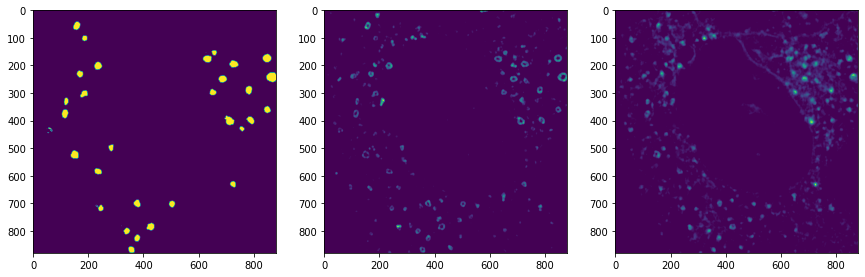

In [47]:
k = 4
# print(eval_tifpath_list[k])
golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
plt.figure(figsize=(20, 5))
plt.subplot(141)
plt.imshow(np.array(unpad_mask_list[k] > threshold, dtype=np.bool_))
plt.subplot(142)
plt.imshow(golgi_image_list[k][0])
plt.subplot(143)
plt.imshow(golgi_image_list[k][1])

## deal with mask

In [55]:
threshold = 0.1

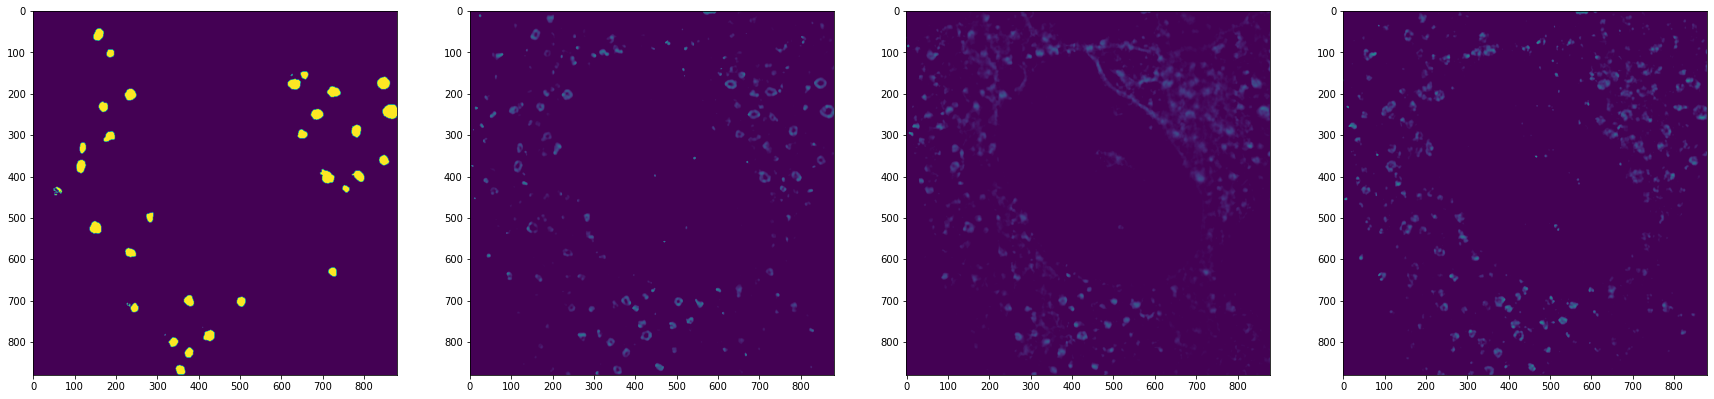

In [56]:
k = 4
# print(eval_tifpath_list[k])
thres_mask = np.array(unpad_mask_list[k] > threshold, dtype=np.uint8)
golgi = tf.keras.utils.normalize(golgi_image_list[k], axis=1)
# golgi = golgi_image_list[k]
plt.figure(figsize=(30, 10))
plt.subplot(141)
plt.imshow(thres_mask)
plt.subplot(142)
plt.imshow(golgi[0])
plt.subplot(143)
plt.imshow(golgi[1])
if golgi_image_list[k].shape[0] == 3:
    plt.subplot(144)
    plt.imshow(golgi[2])

In [ ]:
test_giantin_patches = tf.keras.utils.normalize(patches_giantin_list[k], axis=1)
test_pred_mask_patches = pred_mask_patches[k]
nrow = int(np.sqrt(test_giantin_patches.shape[0]))
plt.figure(figsize=(20, 10))

for i, patch in enumerate(test_giantin_patches):
    pos = i // nrow * nrow + i + 1
    plt.subplot(nrow, 2 * nrow, pos)
    plt.imshow(patch)

    plt.subplot(nrow, 2 * nrow, pos + nrow)
    plt.imshow(test_pred_mask_patches[i])

In [ ]:
test_pred_mask_patches = pred_mask_patches[k]
nrow = int(np.sqrt(test_pred_mask_patches.shape[0]))
plt.figure(figsize=(10, 10))

for i, patch in enumerate(test_pred_mask_patches):
    plt.subplot(nrow, nrow, i + 1)
    plt.imshow(patch)

## find contours on mask

In [106]:
threshold = 0.3
k = 2
thres_mask = np.array(unpad_mask_list[k] > threshold, dtype=np.uint8)

In [107]:
import cv2

In [108]:
contours, _ = cv2.findContours(thres_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [109]:
contour_area_threshold = 150
giantin_possibility_threshold = 0.1
giantin_channel = 0

0
479 730


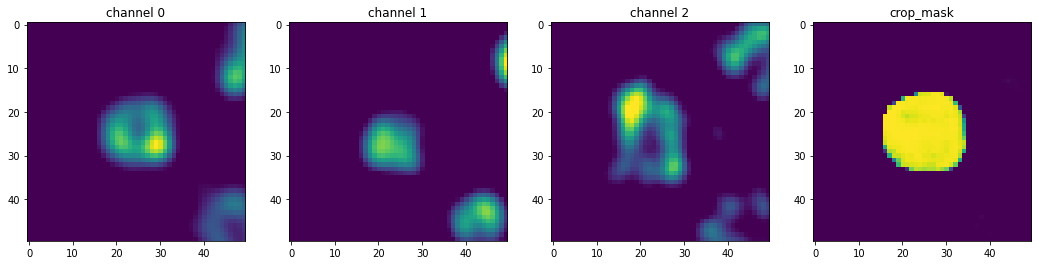

Circle match: 0.034539271657671566
circularity is 0.826503494669248
ratio of minAreaRect :0.8571428571428571
ratio of minEnclosingCircle :0.7421808161589531
ratio of boundingRect :0.7
circle: 0.034539271657671566
ellipse: 0.2834622192134096


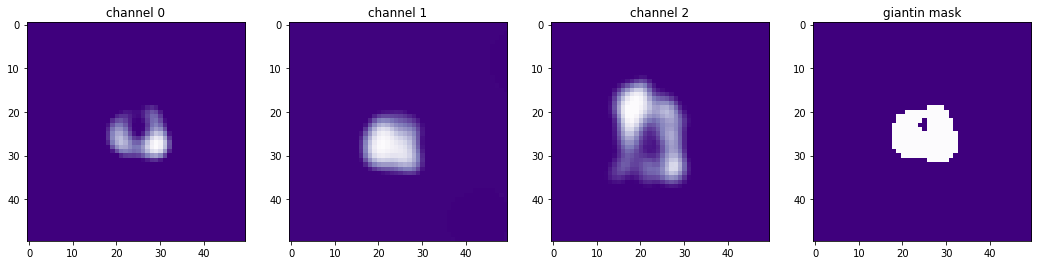

new rect_size: 34
479 730


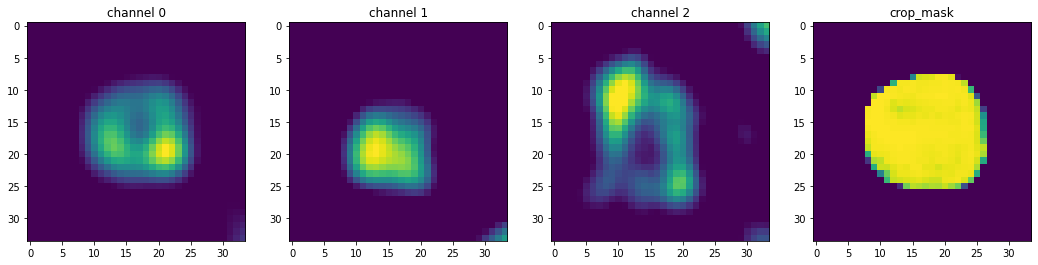

Circle match: 0.034539271657671566
circularity is 0.826503494669248
ratio of minAreaRect :0.8571428571428571
ratio of minEnclosingCircle :0.7421808161589531
ratio of boundingRect :0.7
circle: 0.034539271657671566
ellipse: 0.2834622192134102


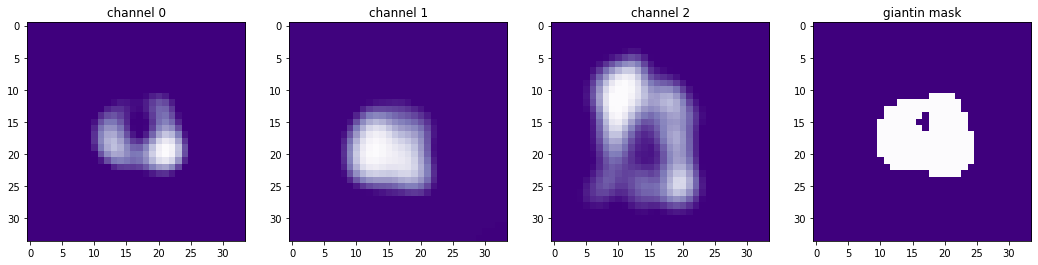

(349.4931, 349.5028)
1
281 520


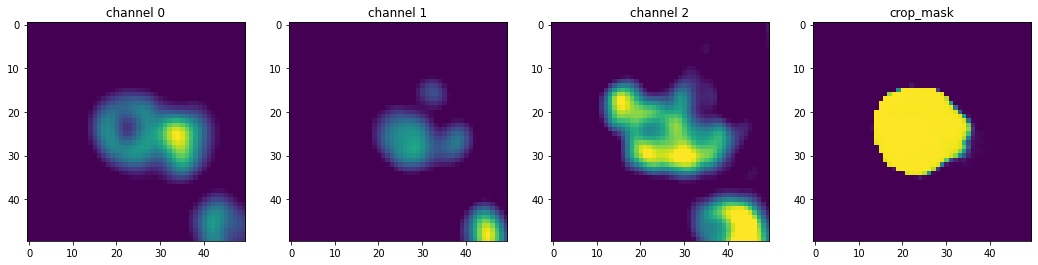

crop had convex, and not satisfied.


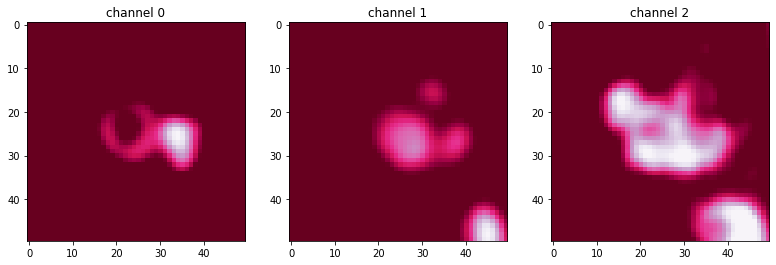

2
288 419


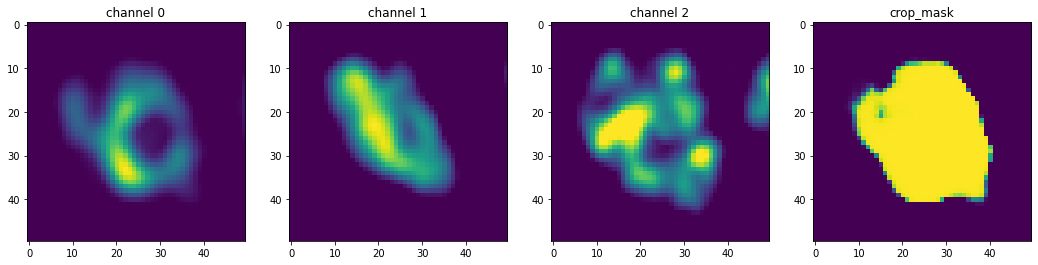

Circle match: 0.05348564810319889
circularity is 0.6609879549425131
ratio of minAreaRect :0.8844443975553404
ratio of minEnclosingCircle :0.601677060528462
ratio of boundingRect :0.6605113636363636
circle: 0.05348564810319889
ellipse: 0.2545009629769048


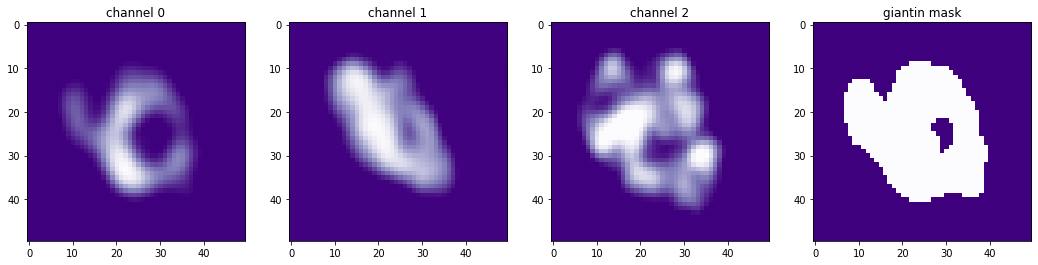

(349.4881, 349.509)
3
456 364


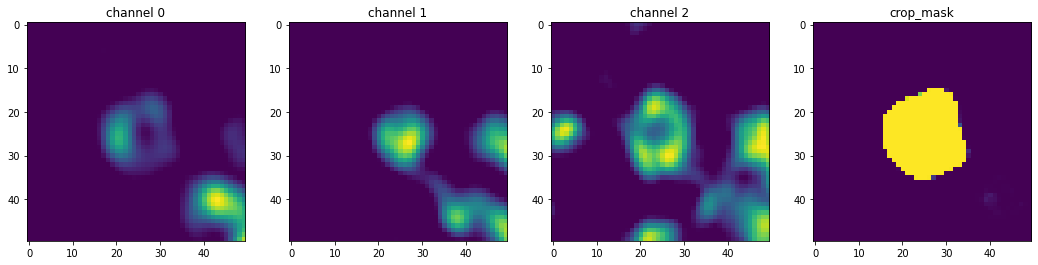

Circle match: 0.015031143929276514
circularity is 0.8350689706170206
ratio of minAreaRect :0.9411764705882353
ratio of minEnclosingCircle :0.7659094791984498
ratio of boundingRect :0.7254901960784313
circle: 0.015031143929276514
ellipse: 0.37995496671410933


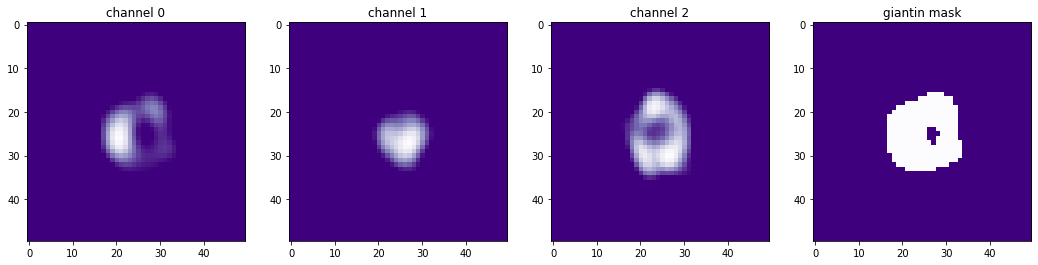

new rect_size: 40
456 364


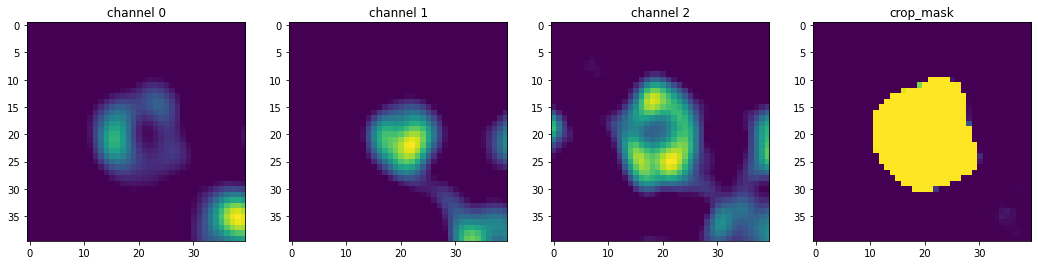

Circle match: 0.015031143929276514
circularity is 0.8350689706170206
ratio of minAreaRect :0.9411764705882353
ratio of minEnclosingCircle :0.7659094791984498
ratio of boundingRect :0.7254901960784313
circle: 0.015031143929276514
ellipse: 0.37995496671411066


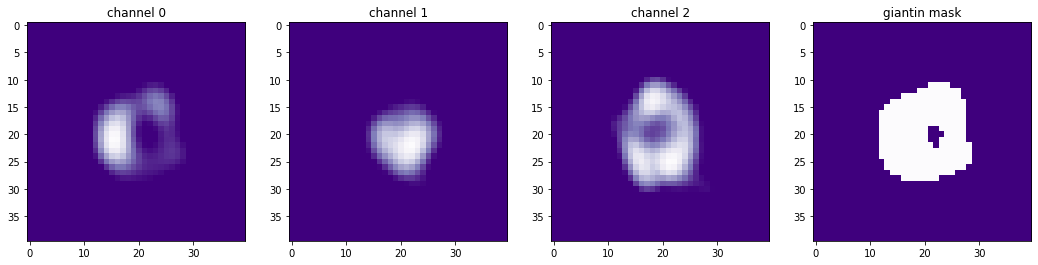

(349.4953, 349.4858)


In [110]:
from functions import check_contours, cal_gyradius, cal_center_of_mass, shift_make_border, normalize_total_intensity

golgi_image = golgi_image_list[k].transpose((1, 2, 0))
pred_mask = unpad_mask_list[k]
finished_golgi_list = []
target_size = 701
center_coordinate = (350, 350)
for i, contour in enumerate(contours):
    print(i)
    contourArea = cv2.contourArea(contour)
    if i == 17:
        print("aaa")
    if cv2.contourArea(contour) < contour_area_threshold:
        print("Area of contour too small: {}".format(contourArea))
        continue
    rect_size = 50
    sub_list = None
    for _ in range(2):
        crop_golgi, giantin_contour, flag, sub_list = check_contours(golgi_image, pred_mask, contour,
                                                                     giantin_channel=giantin_channel,
                                                                     min_giantin_area=contour_area_threshold,
                                                                     sub_list=sub_list,
                                                                     giantin_possibility_threshold=giantin_possibility_threshold,
                                                                     rect_size=rect_size,
                                                                     show_plt=True, overlapping=False)
        if flag:
            crop_giantin = crop_golgi[:, :, giantin_channel]
            mx, my = cal_center_of_mass(crop_giantin, giantin_contour)
            gyradius = cal_gyradius(crop_giantin, mx, my)
            if rect_size > gyradius * target_size / 100:
                rect_size = int(gyradius * target_size / 100)
                print("new rect_size: {}".format(rect_size))
                continue
            else:
                new_size = [int(size * 100 / gyradius) for size in crop_giantin.shape]
                resized_golgi = cv2.resize(crop_golgi, new_size, interpolation=cv2.INTER_LINEAR)
                normalized_golgi = normalize_total_intensity(resized_golgi, target_total_intensity=200000000)
                shifted_golgi = shift_make_border(normalized_golgi, border_size=(target_size, target_size),
                                                  center_coord=center_coordinate, giantin_channel=giantin_channel)
                finished_golgi_list.append(shifted_golgi)
                break
        else:
            break

In [ ]:
# TEST ONE CONTOUR.
from functions import check_contours, cal_gyradius, cal_center_of_mass, shift_make_border, normalize_total_intensity

golgi_image = golgi_image_list[k].transpose((1, 2, 0))
pred_mask = unpad_mask_list[k]
target_size = 701
center_coordinate = (350, 350)
rect_size = 50
sub_list = None
finished_golgi_list = []
for _ in range(2):
    crop_golgi, giantin_contour, flag, sub_list = check_contours(golgi_image, pred_mask, contours[0],
                                                                 giantin_channel=giantin_channel,
                                                                 min_giantin_area=contour_area_threshold,
                                                                 sub_list=sub_list,
                                                                 giantin_possibility_threshold=giantin_possibility_threshold,
                                                                 rect_size=rect_size,
                                                                 show_plt=True, overlapping=False)
    if flag:
        crop_giantin = crop_golgi[:, :, giantin_channel]
        mx, my = cal_center_of_mass(crop_giantin, giantin_contour)
        gyradius = cal_gyradius(crop_giantin, mx, my)
        if rect_size > gyradius * target_size / 100:
            rect_size = int(gyradius * target_size / 100)
            continue
        new_size = [int(size * 100 / gyradius) for size in crop_giantin.shape]
        resized_golgi = cv2.resize(crop_golgi, new_size, interpolation=cv2.INTER_LINEAR)
        normalized_golgi = normalize_total_intensity(resized_golgi, target_total_intensity=200000000)
        shifted_golgi = shift_make_border(normalized_golgi, border_size=(target_size, target_size),
                                          center_coord=center_coordinate, giantin_channel=giantin_channel)
        finished_golgi_list.append(shifted_golgi)
        break
    else:
        break
        microscopy
        microscope

In [ ]:
plt.imshow(shifted_golgi[:, :, 0])

In [ ]:
tifffile.imsave(data=unpad_mask_list[k], file="pred_for_report.tif")

In [ ]:
finished_golgi_list = np.array(finished_golgi_list)

In [ ]:
mean_golgi = np.mean(finished_golgi_list, axis=0)
print(mean_golgi.shape)

In [ ]:
plt.imshow(mean_golgi[:, :, 1])

In [ ]:
fig = mean_golgi
f = plt.figure(figsize=(20, 5))
ax = plt.subplot(141)
a = plt.imshow(fig[:, :, 0])
plt.colorbar(a, ax=ax)

ax = plt.subplot(142)
b = plt.imshow(fig[:, :, 1])
plt.colorbar(b, ax=ax)
ax = plt.subplot(143)

a = plt.imshow(fig[:, :, 0])
plt.colorbar(a, ax=ax)

ax = plt.subplot(144)
b = plt.imshow(fig[:, :, 1])
plt.colorbar(b, ax=ax)
# plt.subplot(133)
# plt.imshow(fig[:, :, 2])
plt.show()

In [ ]:
from functions import cal_radial_mean_intensity

df_list, radius_list = cal_radial_mean_intensity(fig)

In [ ]:
df_list[0]

In [ ]:
for df in df_list:
    df["normalized_radius"] = df.index / radius_list[0]

In [ ]:
mean_intensity_list = df_list[0]["mean_intensity"].to_list()

In [ ]:
for i, cur_intensity in df_list[0]["mean_intensity"][::-1].iteritems():
    # if pd.isna(cur_intensity):
    #     print(i)
    #     continue
    if i == r_peak:
        print(0)
        break
    pre_intensity = df_list[0]["mean_intensity"].iloc[i - 1]
    if pre_intensity >= FWHM >= cur_intensity:
        if pre_intensity - FWHM >= FWHM - cur_intensity:
            print(i)
        else:
            print(i - 1)
        break


In [ ]:
df_list[0]["mean_intensity"][::-1]

In [ ]:
writer = pd.ExcelWriter('output.xlsx')

In [ ]:
df_list[0].to_excel(writer, sheet_name='C1')

In [ ]:
writer.save()

In [ ]:
plt.figure(figsize=(10, 7))
ax = plt.axes()
ax.plot(df_list[0]['normalized_radius'],df_list[0]['normalized_mean_intensity'])
ax.plot(df_list[0]['normalized_radius'],df_list[1]['normalized_mean_intensity'])
# ax.plot(df_list[2]['mean_intensity'])

In [ ]:
import pandas as pd

data = np.array(pd.read_csv("../try/try1.csv"))

In [ ]:
data.shape + (3, )

In [ ]:
np.expand_dims(data).shape

In [ ]:
cmap_list = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']

In [ ]:
data.dtype

In [ ]:
data.astype(np.bool_)

In [ ]:
for cmap in cmap_list:
    plt.imshow(data,cmap=cmap)
    plt.title(cmap)
    plt.colorbar()
    plt.show()

In [ ]:
from matplotlib.patches import Rectangle

fig = mean_golgi
plt.figure(figsize=(20, 3))
ax = plt.subplot(141)
a = plt.imshow(data)
plt.colorbar(a, ax=ax)

ax = plt.subplot(142)
b = plt.imshow(data[200:300, 200:300])
plt.colorbar(b, ax=ax)
ax = plt.subplot(143)

a = plt.imshow(data)
plt.colorbar(a, ax=ax)

ax = plt.subplot(144)
b = plt.imshow(data)
ax.add_patch(Rectangle((0.5, 0.5,), 700, 700, facecolor="white", alpha=0.3))
ax.add_patch(Rectangle((-0.5, -0.5), 700, 700, fill=False, edgecolor="red", linewidth=8))
plt.colorbar(b, ax=ax)
# plt.subplot(133)
# plt.imshow(fig[:, :, 2])
plt.show()

In [ ]:
import os

os.path.split(" C:/Users/JIAZ0006/Desktop/NTU/BS6211/Enface-giantin-project/jupyter_data/eval/c1/20181025-VSVGwt-Flag-594-ST6-moxGFP-5mBiotin-Noc-03")